In [1]:
#CODE TO IMPORT FLIGHT TRACKING DATA AND DETERMINE AREA FROM MOVEMENTS
#import libraries

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import sklearn.mixture as mix
from matplotlib import cm
import random
from sklearn.utils import check_random_state
import collections
import warnings
import math

np.random.seed(100)

# directory

os.chdir("C:\\Users\mark.fowler\OneDrive - Liverpool School of Tropical Medicine\LSTM\MIRA\Flight Tracking")
print(os.getcwd())




C:\Users\mark.fowler\OneDrive - Liverpool School of Tropical Medicine\LSTM\MIRA\Flight Tracking


In [2]:
##PREP DATA############

#IMPORT RAW DATA AND CALCULATE STEP AND ANGLE CHANGE
## FINDS CHANGE BETWEEN x & y BETWEEN STEPS.  TAKES THIS AS 2 SIDES OF A RIGHT ANGLE TRIANGLE (DISTANCE CHANGE = HYPOTENEUSE).  USE PYTHAG'S THEOREM TO CALCULATE THE STEP CHANGE
## THEN USE TRIG TO CALCULATE THE ANGLE CHANGE (UNSING INVERSE COSINE)

#IMPORT DATA
xls = pd.ExcelFile('scikit-learn data.xlsx')
raw = pd.read_excel(xls, 'Data')


#BUILD RIGHT ANGLED TRIANGLE FROM WHICH STEP (HYPOTENEUSE) AND ANGLE CAN BE CALCULATED
#CALCULATE LENGTH OF 1st side of right angled tri 
for i in range(len(raw)):
    if i > 0 and i < len(raw) :
        raw.loc[i,'sideX'] = raw.loc[i,'X(mm)'] - raw.loc[i-1,'X(mm)']

#CALCULATE LENGTH OF 2nd side of right angled tri        
for i in range(len(raw)):
    if i > 0 and i < len(raw) :
        raw.loc[i,'sideY'] = raw.loc[i,'Y(mm)'] - raw.loc[i-1,'Y(mm)']

        
        
#RESET INITIAL sides of each flight
raw.loc[0,'sideX'] = 0
for i in range(len(raw)):
    if i > 0 and i < len(raw)-1 :
        if raw.loc[i,'Mosquito Id'] != raw.loc[i-1,'Mosquito Id']:
            raw.loc[i,'sideX'] = 0
            
raw.loc[0,'sideY'] = 0
for i in range(len(raw)):
    if i > 0 and i < len(raw)-1 :
        if raw.loc[i,'Mosquito Id'] != raw.loc[i-1,'Mosquito Id']:
            raw.loc[i,'sideY'] = 0



            
#FIND WHICH QUADRANT THE TRIANGLE IS IN (NEEDED FOR TRIG - WHICH ANGLE ARE WE DERIVING?)
for i in range(len(raw)):
    if  raw.loc[i,'sideX'] > 0 and raw.loc[i,'sideY'] > 0:
        raw.loc[i,'quad'] = 'Q1'
    elif  raw.loc[i,'sideX'] > 0 and raw.loc[i,'sideY'] < 0:
        raw.loc[i,'quad'] = 'Q2'
    elif  raw.loc[i,'sideX'] < 0 and raw.loc[i,'sideY'] < 0:
        raw.loc[i,'quad'] = 'Q3'
    elif  raw.loc[i,'sideX'] < 0 and raw.loc[i,'sideY'] > 0:
        raw.loc[i,'quad'] = 'Q4'
    else:
        raw.loc[i,'quad'] = 'XX'
    

    
#convert side length to absolute values for calculations    
raw['sideX'] = abs(raw['sideX'])
raw['sideY'] = abs(raw['sideY'])



#FIND WHICH WHICH HALF OF THE QUADRANT THE TRIANGLE IS IN  (NEEDED FOR TRIG - WHICH ANGLE ARE WE DERIVING?)
for i in range(len(raw)):
    if  raw.loc[i,'quad'] == 'Q1' and raw.loc[i,'sideX'] < raw.loc[i,'sideY']:
        raw.loc[i,'quad'] = 'Q1A'
    elif  raw.loc[i,'quad'] == 'Q1' and raw.loc[i,'sideX'] > raw.loc[i,'sideY']:
        raw.loc[i,'quad'] = 'Q1B'  
    elif  raw.loc[i,'quad'] == 'Q2' and raw.loc[i,'sideX'] > raw.loc[i,'sideY']:
        raw.loc[i,'quad'] = 'Q2A'   
    elif  raw.loc[i,'quad'] == 'Q2' and raw.loc[i,'sideX'] < raw.loc[i,'sideY']:
        raw.loc[i,'quad'] = 'Q2B'  
    elif  raw.loc[i,'quad'] == 'Q3' and raw.loc[i,'sideX'] < raw.loc[i,'sideY']:
        raw.loc[i,'quad'] = 'Q3A'    
    elif  raw.loc[i,'quad'] == 'Q3' and raw.loc[i,'sideX'] > raw.loc[i,'sideY']:
        raw.loc[i,'quad'] = 'Q3B'  
    elif  raw.loc[i,'quad'] == 'Q4' and raw.loc[i,'sideX'] > raw.loc[i,'sideY']:
        raw.loc[i,'quad'] = 'Q4A'  
    elif  raw.loc[i,'quad'] == 'Q4' and raw.loc[i,'sideX'] < raw.loc[i,'sideY']:
        raw.loc[i,'quad'] = 'Q4B'  
    else:
        raw.loc[i,'quad'] = 'XX'


        
        

#use pythagoras' theorem to calcuculate the hypotenuse (i.e., the step)
## c squared = a sqaured + b squared
raw['Hyp'] = (raw['sideX'] * raw['sideX']) + (raw['sideY'] * raw['sideY'])
## find square root of c
raw['Hyp'] = raw['Hyp']**(1/2)




# use trigonometry to calculate angle of movement
## need to use the inverse cos or inverse sine depending on the position of the triangle
for i in range(len(raw)):
    if raw.loc[i,'quad'] in ["Q1A", "Q2B", "Q3A", "Q4B"]:
        raw.loc[i,'angle'] =  math.degrees( math.asin(raw.loc[i,'sideX'] / raw.loc[i,'Hyp']) )
    elif raw.loc[i,'quad'] in ["Q1B", "Q2A", "Q3B", "Q4A"]:
        raw.loc[i,'angle'] =  math.degrees( math.acos(raw.loc[i,'sideX'] / raw.loc[i,'Hyp']) )
    else:
        raw.loc[i,'angle'] = 0
    

    
#use quadrant info to add the correct number of degrees to the triangle angle
for i in range(len(raw)):
    if  raw.loc[i,'quad'] == 'Q1A':
        raw.loc[i,'angle'] = raw.loc[i,'angle']
    elif  raw.loc[i,'quad'] == 'Q1B':
        raw.loc[i,'angle'] = raw.loc[i,'angle'] + 45
    elif  raw.loc[i,'quad'] == 'Q2A' :
        raw.loc[i,'angle'] = raw.loc[i,'angle'] + 90
    elif  raw.loc[i,'quad'] == 'Q2B' :
        raw.loc[i,'angle'] = raw.loc[i,'angle'] + 135
    elif  raw.loc[i,'quad'] == 'Q3A' :
        raw.loc[i,'angle'] = raw.loc[i,'angle'] + 180
    elif  raw.loc[i,'quad'] == 'Q3B' :
        raw.loc[i,'angle'] = raw.loc[i,'angle'] + 225
    elif  raw.loc[i,'quad'] == 'Q4A' :
        raw.loc[i,'angle'] = raw.loc[i,'angle'] + 270
    elif  raw.loc[i,'quad'] == 'Q4V' :
        raw.loc[i,'angle'] = raw.loc[i,'angle'] + 315
    else:        
        raw.loc[i,'angle'] = raw.loc[i,'angle']



    
#reset initial angle for each flight
raw.loc[0,'angle'] = 0
for i in range(len(raw)):
    if i > 0 and i < len(raw)-1 :
        if raw.loc[i,'Mosquito Id'] != raw.loc[i-1,'Mosquito Id']:
            raw.loc[i,'angle'] = 0

            

            

#raw.to_csv('raw.csv')
            
            
            
#clean_ data
raw.drop(['Area Label','Frame No','Frame Time(umsecs)', 'sideX', 'sideY', 'quad'], axis=1, inplace=True)
raw = raw.rename(columns = {"Mosquito Id" : "ID",
                            "X(mm)": "x", 
                            "Y(mm)":"y", 
                            "Activity Mode":"Activity",
                            "Frame Time (secs)": "TimeS",
                           "Hyp": "step"}) 




df = raw
orig_df = df
raw

ID            x           y  Activity    TimeS        step       angle
0        1   591.182211    8.461140         2    42.94    0.000000    0.000000
1        1   598.048507   15.812189         2    42.96   10.059024   43.047209
2        1   604.856851   24.796524         2    42.98   11.272613   37.154908
3        1   611.711187   32.494292         2    43.00   10.307161   41.682878
4        1   618.899796   41.792434         2    43.02   11.752937   37.708440
5        1   625.094156   51.765152         2    43.04   11.739898   31.845681
6        1   632.688830   58.149823         2    43.06    9.921850   85.053009
7        1   639.724242   65.717424         2    43.08   10.332745   42.912849
8        1   647.081380   72.932943         2    43.10   10.304911   89.443208
9        1   653.886447   80.552198         2    43.12   10.215771   41.769338
10       1   661.094298   89.631579         2    43.14   11.592596   38.445018
11       1   667.696899   99.246512         2    43.16   11.663673   34.477494
12       1   674.926890  108.171623         2    43.18   11.486095   39.009992
13       1   681.533486  117.352359         2    43.20   11.310748   35.739359
14       1   687.992101  125.309637         2    43.22   10.248511   39.064908
15       1   693.919192  132.615440         2    43.24    9.407719   39.051911
16       1   699.658692  139.532695         2    43.26    8.988342   39.683738
17       1   705.149057  146.339623         2    43.28    8.745191   38.889122
18       1   710.149936  153.294080         2    43.30    8.565820   35.719526
19       1   715.742424  159.150253         2    43.32    8.097573   43.680604
20       1   719.936039  166.325338         2    43.34    8.310732   30.304962
21       1   725.546358  171.930464         2    43.36    7.930517   89.973471
22       1   730.200946  179.427305         2    43.38    8.824274   31.835038
23       1   734.865125  187.143545         3    43.40    9.016370   31.151397
24       1   742.139373  182.277003         3    43.48    8.752023  123.782904
25       1   742.508916  177.514403         3    43.50    4.776916  139.436850
26       1   744.371919  174.803859         3    43.52    3.289047  169.501384
27       1   747.184239  173.133120         3    43.54    3.271163  120.713626
28       1   750.504747  171.998418         3    43.56    3.509035  108.866610
29       1   755.347722  171.598921         3    43.58    4.859424   94.715650
...    ...          ...         ...       ...      ...         ...         ...
14345  176  1068.598413  625.026984         2  7120.71    2.954013   29.372145
14346  176  1068.231638  627.477401         2  7120.73    2.477714    8.512739
14347  176  1067.959770  767.201149         2  7123.55  139.724013    0.111483
14348  176  1070.988288  768.672072         2  7123.57    3.366829   70.905407
14349  176  1075.618056  769.494048         2  7123.59    4.702169   55.067471
14350  176  1080.190476  770.398194         2  7123.61    4.660956   56.185318
14351  176  1084.687276  771.751792         2  7123.63    4.696109   61.752515
14352  176  1089.370674  772.529144         2  7123.65    4.747472   54.424055
14353  176  1093.786988  773.471480         2  7123.67    4.515730   57.044917
14354  176  1098.166667  773.869763         2  7123.69    4.397752   50.196129
14355  176  1102.381313  774.364478         2  7123.71    4.243582   51.694740
14356  176  1106.542115  774.461470         2  7123.73    4.161932   46.335366
14357  176  1110.557116  774.519663         2  7123.75    4.015423   45.830386
14358  176  1114.778333  774.500000         2  7123.77    4.221263   90.266888
14359  176  1118.898649  774.618243         2  7123.79    4.122012   46.643801
14360  176  1123.164557  775.272152         2  7123.81    4.315735   53.714868
14361  176  1127.677156  776.212121         2  7123.83    4.609457   56.766396
14362  176  1131.455833  776.867500         2  7123.85    3.835091   54.839571
14363  176  1135.592381  777.637143         2  7123.87    

In [3]:
#calculate change in time since last step
## do not know if this time step is signal or noise - not every step is 0.02
for i in range(len(df)):
    if i > 0 and i < len(df)-1 :
        df.loc[i,'Time_Change'] = df.loc[i,'TimeS'] - df.loc[i-1,'TimeS']

#reset new time change fields of first frame of each flight to 0
df.loc[0,'Time_Change'] = 0

for i in range(len(df)):
    if i > 0 and i < len(df)-1 :
        if df.loc[i,'ID'] != df.loc[i-1,'ID']:
            df.loc[i,'Time_Change'] = 0
            

df.fillna(0, inplace=True)


#calculate linear speed
##bogdged but seems to work
# l_speed = distance / time
for i in range(len(df)):
    if df.loc[i,'Time_Change'] != 0 :
        df.loc[i,'l_speed'] = df.loc[i,'step'] / (df.loc[i,'Time_Change'] * 100)
    else:
        df.loc[i,'l_speed'] = 0

        
#calculate rotational speed
##bogdged but seems to work
# a_speed = angle / time
for i in range(len(df)):
    if df.loc[i,'Time_Change'] != 0 :
        df.loc[i,'a_speed'] = df.loc[i,'angle'] / (df.loc[i,'Time_Change'] * 100)
    else:
        df.loc[i,'a_speed'] = 0

df

ID            x           y  Activity    TimeS        step  \
0        1   591.182211    8.461140         2    42.94    0.000000   
1        1   598.048507   15.812189         2    42.96   10.059024   
2        1   604.856851   24.796524         2    42.98   11.272613   
3        1   611.711187   32.494292         2    43.00   10.307161   
4        1   618.899796   41.792434         2    43.02   11.752937   
5        1   625.094156   51.765152         2    43.04   11.739898   
6        1   632.688830   58.149823         2    43.06    9.921850   
7        1   639.724242   65.717424         2    43.08   10.332745   
8        1   647.081380   72.932943         2    43.10   10.304911   
9        1   653.886447   80.552198         2    43.12   10.215771   
10       1   661.094298   89.631579         2    43.14   11.592596   
11       1   667.696899   99.246512         2    43.16   11.663673   
12       1   674.926890  108.171623         2    43.18   11.486095   
13       1   681.533486  117.352359         2    43.20   11.310748   
14       1   687.992101  125.309637         2    43.22   10.248511   
15       1   693.919192  132.615440         2    43.24    9.407719   
16       1   699.658692  139.532695         2    43.26    8.988342   
17       1   705.149057  146.339623         2    43.28    8.745191   
18       1   710.149936  153.294080         2    43.30    8.565820   
19       1   715.742424  159.150253         2    43.32    8.097573   
20       1   719.936039  166.325338         2    43.34    8.310732   
21       1   725.546358  171.930464         2    43.36    7.930517   
22       1   730.200946  179.427305         2    43.38    8.824274   
23       1   734.865125  187.143545         3    43.40    9.016370   
24       1   742.139373  182.277003         3    43.48    8.752023   
25       1   742.508916  177.514403         3    43.50    4.776916   
26       1   744.371919  174.803859         3    43.52    3.289047   
27       1   747.184239  173.133120         3    43.54    3.271163   
28       1   750.504747  171.998418         3    43.56    3.509035   
29       1   755.347722  171.598921         3    43.58    4.859424   
...    ...          ...         ...       ...      ...         ...   
14345  176  1068.598413  625.026984         2  7120.71    2.954013   
14346  176  1068.231638  627.477401         2  7120.73    2.477714   
14347  176  1067.959770  767.201149         2  7123.55  139.724013   
14348  176  1070.988288  768.672072         2  7123.57    3.366829   
14349  176  1075.618056  769.494048         2  7123.59    4.702169   
14350  176  1080.190476  770.398194         2  7123.61    4.660956   
14351  176  1084.687276  771.751792         2  7123.63    4.696109   
14352  176  1089.370674  772.529144         2  7123.65    4.747472   
14353  176  1093.786988  773.471480         2  7123.67    4.515730   
14354  176  1098.166667  773.869763         2  7123.69    4.397752   
14355  176  1102.381313  774.364478         2  7123.71    4.243582   
14356  176  1106.542115  774.461470         2  7123.73    4.161932   
14357  176  1110.557116  774.519663         2  7123.75    4.015423   
14358  176  1114.778333  774.500000         2  7123.77    4.221263   
14359  176  1118.898649  774.618243         2  7123.79    4.122012   
14360  176  1123.164557  775.272152         2  7123.81    4.315735   
14361  176  1127.677156  776.212121         2  7123.83    4.609457   
14362  176  1131.455833  776.867500         2  7123.85    3.835091   
14363  176  1135.592381  777.637143         2  7123.87    4.207538   
14364  176  1139.592381  778.092381         2  7123.89    4.025822   
14365  176  1142.868009  779.321029         2  7123.91    3.498473   
14366  176  1147.088675  779.366453         2  7123.93    4.220911   
14367  176  1151.064257  779.549197         2  7123.95    3.979780   
14368  176  1155.292982  779.713158         2  7123.97    4.231903   
14369  176  1159.266414  778.989899         2  7123.99    4.038720   
14370  176  1163.6

In [4]:
#remove short flights
##SHOULD THE FIRST FLIGHT (I.e., those with step and angle of 0) BE REMOVED?

#Create lengths of individual tracks
counts = np.unique(orig_df['ID'], return_counts=True)

counts_df = window_df = pd.DataFrame({'ID': counts[0],
                                      'count': counts[1]})

#merge counts in to dataframe
df = pd.merge(df, counts_df, how='left', left_on=['ID'], right_on=['ID'])

#remove those flights less than 1 second = assuming that 1 frame = 0.02 secs
df = df[df['count'] > 150]


#remove counts col
df.drop(df.columns[10], axis=1, inplace=True) 
# remove timeS
df.drop(df.columns[4], axis=1, inplace=True)

df.head()

ID           x          y  Activity       step      angle  Time_Change  \
0   1  591.182211   8.461140         2   0.000000   0.000000         0.00   
1   1  598.048507  15.812189         2  10.059024  43.047209         0.02   
2   1  604.856851  24.796524         2  11.272613  37.154908         0.02   
3   1  611.711187  32.494292         2  10.307161  41.682878         0.02   
4   1  618.899796  41.792434         2  11.752937  37.708440         0.02   

    l_speed    a_speed  
0  0.000000   0.000000  
1  5.029512  21.523604  
2  5.636306  18.577454  
3  5.153581  20.841439  
4  5.876468  18.854220

In [5]:
#build sliding window
   
#how wide is the window?  How many 'frames' are included?
## min length chosen to be 1 second (50 frames) based on the work of M Dickenson
window_size = 10
#how many columns in the dataset?
full_col_no = 9

def window_stack(df, stepsize=1, width= window_size):
    return np.hstack( df[i:1+i-width or None:stepsize] for i in range(0,width) )

win = window_stack(df)




#forl loop to rebuild dataframe
## seperate out individual frames and store them in a seperate, labelled, array
## append those arrays to a dataframe

#declare DFs
window_df = pd.DataFrame() 
window_df_orig = pd.DataFrame()
window_df_x = pd.DataFrame()
window_df_y = pd.DataFrame()



#populate window_df for processing dataset (i.e., remove noise)
for i in range(window_size):
    window_df['id',i] = win[:,(i*full_col_no)]
    #window_df['step',i] = win[:,((i*full_col_no)+4)]
    #window_df['angle',i] = win[:,((i*full_col_no)+5)]
    window_df['Activity',i] = win[:,((i*full_col_no)+3)]
    window_df['l_speed',i] = win[:,((i*full_col_no)+7)]
    window_df['a_speed',i] = win[:,((i*full_col_no)+8)]
#use speed as these are relative and can therefore account for dropped frames
    




#populate orig DF for full dataset (for final output)
for i in range(window_size):
    window_df_orig['id',i] = win[:,(i*full_col_no)]
    window_df_orig['x',i] = win[:,((i*full_col_no)+1)]
    window_df_orig['y',i] = win[:,((i*full_col_no)+2)]
    window_df_orig['Activity',i] = win[:,((i*full_col_no)+3)]
    window_df_orig['step',i] = win[:,((i*full_col_no)+4)]
    window_df_orig['angle',i] = win[:,((i*full_col_no)+5)]
    window_df_orig['time_c',i] = win[:,((i*full_col_no)+6)]
    window_df_orig['l_speed',i] = win[:,((i*full_col_no)+7)]
    window_df_orig['a_speed',i] = win[:,((i*full_col_no)+8)]

    

    
#populate orig DF for x axis dataset (for x average later - used in plotting)
for i in range(window_size):
    window_df_x['x',i] = win[:,((i*full_col_no)+3)]
#calc window x mean
window_df_x['x_mean'] = window_df_x.mean(axis=1)
    
#populate orig DF for y axis dataset (for y average later - used in plotting)
for i in range(window_size):
    window_df_y['x',i] = win[:,((i*full_col_no)+4)]
#calc window y mean
window_df_y['y_mean'] = window_df_y.mean(axis=1)



window_df_means = window_df_x.join(window_df_y, lsuffix='_x', rsuffix='_y')    
window_df_x

window_df_orig = window_df_orig.join(window_df_means['x_mean'])  
window_df_orig = window_df_orig.join(window_df_means['y_mean'])  
window_df_orig


print('current:', window_df.shape)
print('original:', window_df_orig.shape)



window_df




current: (11545, 40)
original: (11545, 92)


(id, 0)  (Activity, 0)  (l_speed, 0)  (a_speed, 0)  (id, 1)  \
0          1.0            2.0      0.000000      0.000000      1.0   
1          1.0            2.0      5.029512     21.523604      1.0   
2          1.0            2.0      5.636306     18.577454      1.0   
3          1.0            2.0      5.153581     20.841439      1.0   
4          1.0            2.0      5.876468     18.854220      1.0   
5          1.0            2.0      5.869949     15.922841      1.0   
6          1.0            2.0      4.960925     42.526505      1.0   
7          1.0            2.0      5.166373     21.456425      1.0   
8          1.0            2.0      5.152455     44.721604      1.0   
9          1.0            2.0      5.107886     20.884669      1.0   
10         1.0            2.0      5.796298     19.222509      1.0   
11         1.0            2.0      5.831837     17.238747      1.0   
12         1.0            2.0      5.743048     19.504996      1.0   
13         1.0            2.0      5.655374     17.869680      1.0   
14         1.0            2.0      5.124256     19.532454      1.0   
15         1.0            2.0      4.703859     19.525956      1.0   
16         1.0            2.0      4.494171     19.841869      1.0   
17         1.0            2.0      4.372595     19.444561      1.0   
18         1.0            2.0      4.282910     17.859763      1.0   
19         1.0            2.0      4.048786     21.840302      1.0   
20         1.0            2.0      4.155366     15.152481      1.0   
21         1.0            2.0      3.965259     44.986736      1.0   
22         1.0            2.0      4.412137     15.917519      1.0   
23         1.0            3.0      4.508185     15.575699      1.0   
24         1.0            3.0      1.094003     15.472863      1.0   
25         1.0            3.0      2.388458     69.718425      1.0   
26         1.0            3.0      1.644524     84.750693      1.0   
27         1.0            3.0      1.635582     60.356813      1.0   
28         1.0            3.0      1.754517     54.433305      1.0   
29         1.0            3.0      2.429712     47.357825      1.0   
...        ...            ...           ...           ...      ...   
11515    160.0            2.0      1.593209     19.281216    160.0   
11516    160.0            2.0      1.353843     22.416404    160.0   
11517    160.0            2.0      0.997690     22.383048    160.0   
11518    160.0            2.0      1.182724     19.567552    160.0   
11519    160.0            2.0      0.998883     20.151808    160.0   
11520    160.0            2.0      1.076656    157.481566    160.0   
11521    160.0            2.0      0.984131      7.471106    160.0   
11522    160.0            2.0      0.915451     15.282746    160.0   
11523    160.0            2.0      1.278308      8.184283    160.0   
11524    160.0            2.0      1.167893      7.091472    160.0   
11525    160.0            2.0      1.222173      6.651181    160.0   
11526    160.0            2.0      1.357076      5.255280    160.0   
11527    160.0            2.0      1.049265      5.233871    160.0   
11528    160.0            2.0      1.308666      4.871540    160.0   
11529    160.0            3.0      1.141174      6.841119    160.0   
11530    160.0            3.0      1.177968      2.503399    160.0   
11531    160.0            3.0      1.002096      0.965713    160.0   
11532    160.0            3.0      1.289507      3.068656    160.0   
11533    160.0            3.0      1.027486      4.874600    160.0   
11534    160.0            3.0      0.003520      0.003937    160.0   
11535    160.0            3.0      1.328702    125.931264    160.0   
11536    160.0            3.0      0.751637    133.198916    160.0   
11537    160.0            2.0      0.955369    106.158765    160.0   
11538    160.0            2.0      0.994430    103.003745    160.0   
11539    160.0            2.0      1.110392    104.131866    160.0   
11540    160.0   

In [6]:
#clean new dataframe - remove overlapping flight windows and remove IDs
##VV code:  https://gist.github.com/Pigrenok/58daae6124ed611c40b7a7d123359644

print('before:', window_df.shape)


idCols = [col for col in window_df.columns if 'id' in col]
isGoodRow = window_df.apply(lambda x: min(x.filter(idCols))==max(x.filter(idCols)),axis=1)
window_df = window_df[isGoodRow]
window_df = window_df.drop(columns=idCols)

print('after:', window_df.shape)
window_df 

before: (11545, 40)
after: (11284, 30)


(Activity, 0)  (l_speed, 0)  (a_speed, 0)  (Activity, 1)  (l_speed, 1)  \
0                2.0      0.000000      0.000000            2.0      5.029512   
1                2.0      5.029512     21.523604            2.0      5.636306   
2                2.0      5.636306     18.577454            2.0      5.153581   
3                2.0      5.153581     20.841439            2.0      5.876468   
4                2.0      5.876468     18.854220            2.0      5.869949   
5                2.0      5.869949     15.922841            2.0      4.960925   
6                2.0      4.960925     42.526505            2.0      5.166373   
7                2.0      5.166373     21.456425            2.0      5.152455   
8                2.0      5.152455     44.721604            2.0      5.107886   
9                2.0      5.107886     20.884669            2.0      5.796298   
10               2.0      5.796298     19.222509            2.0      5.831837   
11               2.0      5.831837     17.238747            2.0      5.743048   
12               2.0      5.743048     19.504996            2.0      5.655374   
13               2.0      5.655374     17.869680            2.0      5.124256   
14               2.0      5.124256     19.532454            2.0      4.703859   
15               2.0      4.703859     19.525956            2.0      4.494171   
16               2.0      4.494171     19.841869            2.0      4.372595   
17               2.0      4.372595     19.444561            2.0      4.282910   
18               2.0      4.282910     17.859763            2.0      4.048786   
19               2.0      4.048786     21.840302            2.0      4.155366   
20               2.0      4.155366     15.152481            2.0      3.965259   
21               2.0      3.965259     44.986736            2.0      4.412137   
22               2.0      4.412137     15.917519            3.0      4.508185   
23               3.0      4.508185     15.575699            3.0      1.094003   
24               3.0      1.094003     15.472863            3.0      2.388458   
25               3.0      2.388458     69.718425            3.0      1.644524   
26               3.0      1.644524     84.750693            3.0      1.635582   
27               3.0      1.635582     60.356813            3.0      1.754517   
28               3.0      1.754517     54.433305            3.0      2.429712   
29               3.0      2.429712     47.357825            3.0      2.929713   
...              ...           ...           ...            ...           ...   
11515            2.0      1.593209     19.281216            2.0      1.353843   
11516            2.0      1.353843     22.416404            2.0      0.997690   
11517            2.0      0.997690     22.383048            2.0      1.182724   
11518            2.0      1.182724     19.567552            2.0      0.998883   
11519            2.0      0.998883     20.151808            2.0      1.076656   
11520            2.0      1.076656    157.481566            2.0      0.984131   
11521            2.0      0.984131      7.471106            2.0      0.915451   
11522            2.0      0.915451     15.282746            2.0      1.278308   
11523            2.0      1.278308      8.184283            2.0      1.167893   
11524            2.0      1.167893      7.091472            2.0      1.222173   
11525            2.0      1.222173      6.651181            2.0      1.357076   
11526            2.0      1.357076      5.255280            2.0      1.049265   
11527            2.0      1.049265      5.233871            2.0      1.308666   
11528            2.0      1.308666      4.871540            3.0      1.141174   
11529            3.0      1.141174      6.841119            3.0      1.177968   
11530            3.0      1.177968      2.503399            3.0      1.002096   
11531            3.0      1.002096      0.965713            3.0      1.289507   
11532            3.0      1.289507    

In [7]:
#determine window behaviour - if all behaviours are of one type than a that behaviour, if not then 0
#reset window_df index as rows have been deleted
window_df = window_df.reset_index(drop=True)

##find activity columns that are all of the same type
actCols = [col for col in window_df.columns if 'Activity' in col]
RowBeh = window_df.apply(lambda x: min(x.filter(actCols))==max(x.filter(actCols)),axis=1)


#if statement to determine behaviour or not
for i in range(len(window_df)):
    if RowBeh.loc[i] == True:
        window_df.loc[i,"Behaviour"] = window_df.iat[i,0]
    else:
        window_df.loc[i,"Behaviour"] = 0

window_df

(Activity, 0)  (l_speed, 0)  (a_speed, 0)  (Activity, 1)  (l_speed, 1)  \
0                2.0      0.000000      0.000000            2.0      5.029512   
1                2.0      5.029512     21.523604            2.0      5.636306   
2                2.0      5.636306     18.577454            2.0      5.153581   
3                2.0      5.153581     20.841439            2.0      5.876468   
4                2.0      5.876468     18.854220            2.0      5.869949   
5                2.0      5.869949     15.922841            2.0      4.960925   
6                2.0      4.960925     42.526505            2.0      5.166373   
7                2.0      5.166373     21.456425            2.0      5.152455   
8                2.0      5.152455     44.721604            2.0      5.107886   
9                2.0      5.107886     20.884669            2.0      5.796298   
10               2.0      5.796298     19.222509            2.0      5.831837   
11               2.0      5.831837     17.238747            2.0      5.743048   
12               2.0      5.743048     19.504996            2.0      5.655374   
13               2.0      5.655374     17.869680            2.0      5.124256   
14               2.0      5.124256     19.532454            2.0      4.703859   
15               2.0      4.703859     19.525956            2.0      4.494171   
16               2.0      4.494171     19.841869            2.0      4.372595   
17               2.0      4.372595     19.444561            2.0      4.282910   
18               2.0      4.282910     17.859763            2.0      4.048786   
19               2.0      4.048786     21.840302            2.0      4.155366   
20               2.0      4.155366     15.152481            2.0      3.965259   
21               2.0      3.965259     44.986736            2.0      4.412137   
22               2.0      4.412137     15.917519            3.0      4.508185   
23               3.0      4.508185     15.575699            3.0      1.094003   
24               3.0      1.094003     15.472863            3.0      2.388458   
25               3.0      2.388458     69.718425            3.0      1.644524   
26               3.0      1.644524     84.750693            3.0      1.635582   
27               3.0      1.635582     60.356813            3.0      1.754517   
28               3.0      1.754517     54.433305            3.0      2.429712   
29               3.0      2.429712     47.357825            3.0      2.929713   
...              ...           ...           ...            ...           ...   
11254            2.0      1.593209     19.281216            2.0      1.353843   
11255            2.0      1.353843     22.416404            2.0      0.997690   
11256            2.0      0.997690     22.383048            2.0      1.182724   
11257            2.0      1.182724     19.567552            2.0      0.998883   
11258            2.0      0.998883     20.151808            2.0      1.076656   
11259            2.0      1.076656    157.481566            2.0      0.984131   
11260            2.0      0.984131      7.471106            2.0      0.915451   
11261            2.0      0.915451     15.282746            2.0      1.278308   
11262            2.0      1.278308      8.184283            2.0      1.167893   
11263            2.0      1.167893      7.091472            2.0      1.222173   
11264            2.0      1.222173      6.651181            2.0      1.357076   
11265            2.0      1.357076      5.255280            2.0      1.049265   
11266            2.0      1.049265      5.233871            2.0      1.308666   
11267            2.0      1.308666      4.871540            3.0      1.141174   
11268            3.0      1.141174      6.841119            3.0      1.177968   
11269            3.0      1.177968      2.503399            3.0      1.002096   
11270            3.0      1.002096      0.965713            3.0      1.289507   
11271            3.0      1.289507    

TRAIN SET = 7898
TEST SET = 3386


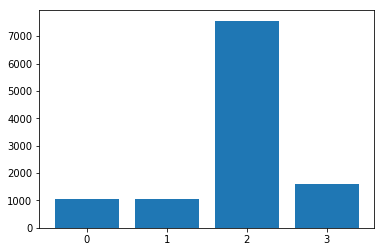

In [21]:
##SPLIT DATA
# Create X and y dataframes
X = window_df.loc[:, [col for col in window_df.columns if col != "Behaviour"]]
y = window_df.loc[:, "Behaviour"]


#Show distributions
count = y.value_counts()
plt.bar(count.index, count)
plt.xticks([0, 1, 2, 3])


# split data
#np.random.seed(123)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

print("TRAIN SET =",len(X_train))
print("TEST SET =",len(X_test))

#scale
#print(X_train)

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train_scale = scaler.transform(X_train)  
# apply same transformation to test data
X_test_scale = scaler.transform(X_test)  


In [15]:
#fit random forset to train set

np.random.seed(100)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



#rf = RandomForestClassifier(max_depth=9, min_samples_split=20, n_estimators=125)
##Old data -67%
rf = RandomForestClassifier(max_depth=9, min_samples_split=10, n_estimators=160)
rf.fit(X_train, y_train)

#predict model on test set

#measure success of model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("conf matrix", confusion_matrix(y_test, rf.predict(X_test)))
print()
print("Report",classification_report(y_test, rf.predict(X_test)))
print()
print(round(accuracy_score(y_test, rf.predict(X_test)),2))


#rf = RandomForestClassifier(max_depth=9, min_samples_split=20, n_estimators=125)

C:\Users\mark.fowler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


conf matrix [[ 290    0    3    5]
 [   0  311    0    0]
 [   0    0 2309    0]
 [   0    0    0  468]]

Report              precision    recall  f1-score   support

        0.0       1.00      0.97      0.99       298
        1.0       1.00      1.00      1.00       311
        2.0       1.00      1.00      1.00      2309
        3.0       0.99      1.00      0.99       468

avg / total       1.00      1.00      1.00      3386


1.0


In [16]:
#fit NeuralNet to train set
np.random.seed(100)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='sgd', alpha=0.001,
                    hidden_layer_sizes=(12), max_iter=1000, random_state=4)

##old data - 70%
#clf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(13), max_iter=1000, random_state=4)

clf.fit(X_train_scale, y_train) 





from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("conf matrix", confusion_matrix(y_test, clf.predict(X_test_scale)))
print()
print("Report",classification_report(y_test, clf.predict(X_test_scale)))
print()
print(round(accuracy_score(y_test, clf.predict(X_test_scale)),2))


# lf = MLPClassifier(solver='sgd', alpha=0.001, hidden_layer_sizes=(13), max_iter=1000, random_state=4)

conf matrix [[ 288    0    4    6]
 [   0  311    0    0]
 [   0    0 2309    0]
 [   0    0    0  468]]

Report              precision    recall  f1-score   support

        0.0       1.00      0.97      0.98       298
        1.0       1.00      1.00      1.00       311
        2.0       1.00      1.00      1.00      2309
        3.0       0.99      1.00      0.99       468

avg / total       1.00      1.00      1.00      3386


1.0
